In [ ]:
!pip install pandas matplotlib contextily numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 4.7 MB/s eta 0:00:0000:0100:01


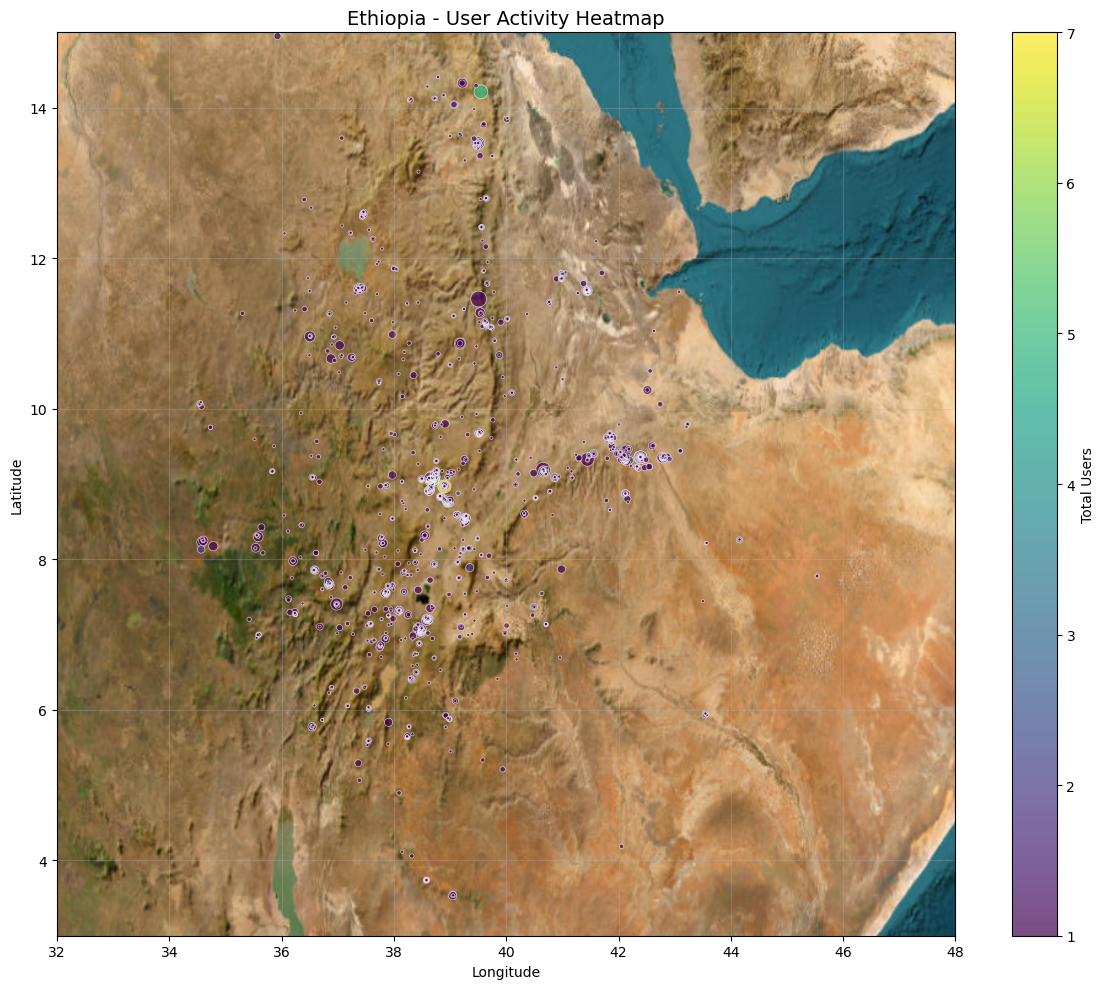

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np

# Read the Excel file
df = pd.read_excel('map.xlsx')  # Replace with your file path

# Extract latitude and longitude
df[['Latitude', 'Longitude']] = df['Custom parameter'].str.extract(r'([\d\.]+),\s*([\d\.]+)').astype(float)

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

# Create a scatter plot sized by Event count and colored by Total users
sc = ax.scatter(
    x=df['Longitude'],
    y=df['Latitude'],
    c=df['Total users'],
    s=df['Event count']*5,  # Adjust scaling factor as needed
    cmap='viridis',
    alpha=0.7,
    edgecolor='white',
    linewidth=0.5
)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Total Users')

# Set Ethiopia-appropriate bounds (approximate)
# You may need to adjust these based on your specific data points
ethiopia_bounds = {
    'min_lon': 32.0,
    'max_lon': 48.0,
    'min_lat': 3.0,
    'max_lat': 15.0
}

ax.set_xlim(ethiopia_bounds['min_lon'], ethiopia_bounds['max_lon'])
ax.set_ylim(ethiopia_bounds['min_lat'], ethiopia_bounds['max_lat'])

# Add satellite map background
ctx.add_basemap(
    ax,
    crs='EPSG:4326',  # WGS84 coordinate reference system
    source=ctx.providers.Esri.WorldImagery,  # Satellite imagery
    attribution=False
)

# Add title and labels
ax.set_title('Ethiopia - User Activity Heatmap', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add grid
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [2]:
import streamlit as st
import pandas as pd
import numpy as np
import pydeck as pdk
import matplotlib.colors as colors
import matplotlib.pyplot as plt  # Add this import

# Set page config
st.set_page_config(layout="wide", page_title="Ethiopia User Activity Map")

# Load data
@st.cache_data
def load_data():
    df = pd.read_excel('map.xlsx')  # Replace with your file path
    df[['Latitude', 'Longitude']] = df['Custom parameter'].str.extract(r'([\d\.]+),\s*([\d\.]+)').astype(float)
    return df

df = load_data()

# Sidebar controls
st.sidebar.header("Map Controls")
min_events = int(df['Event count'].min())
max_events = int(df['Event count'].max())
event_size = st.sidebar.slider(
    "Event size scaling",
    min_value=1,
    max_value=20,
    value=5,
    help="Adjust the size of points based on event count"
)

min_users = int(df['Total users'].min())
max_users = int(df['Total users'].max())
selected_users = st.sidebar.slider(
    "Filter by user count",
    min_value=min_users,
    max_value=max_users,
    value=(min_users, max_users)
)

# Filter data based on user selection
filtered_df = df[(df['Total users'] >= selected_users[0]) & (df['Total users'] <= selected_users[1])]

# Normalize user counts for color scale
norm = colors.Normalize(vmin=filtered_df['Total users'].min(), vmax=filtered_df['Total users'].max())
color_scale = plt.cm.viridis(norm(filtered_df['Total users'])) * 255  # Changed colors.plt.cm to plt.cm
color_scale = color_scale[:, :3].tolist()  # Convert to RGB format

# Prepare data for pydeck
filtered_df['radius'] = filtered_df['Event count'] * event_size
filtered_df['color'] = color_scale

# Create tooltip
tooltip = {
    "html": "<b>Location:</b> {Location}<br/>"
            "<b>Total Users:</b> {Total users}<br/>"
            "<b>Event Count:</b> {Event count}",
    "style": {
        "backgroundColor": "steelblue",
        "color": "white"
    }
}

# Create pydeck chart
view_state = pdk.ViewState(
    latitude=filtered_df['Latitude'].mean(),
    longitude=filtered_df['Longitude'].mean(),
    zoom=5,
    pitch=0
)

layer = pdk.Layer(
    "ScatterplotLayer",
    filtered_df,
    get_position=['Longitude', 'Latitude'],
    get_radius='radius',
    get_fill_color='color',
    pickable=True,
    auto_highlight=True,
    opacity=0.8,
    stroked=True,
    get_line_color=[0, 0, 0],
    line_width_min_pixels=1
)

# Render the map
st.pydeck_chart(
    pdk.Deck(
        map_style='satellite',
        initial_view_state=view_state,
        layers=[layer],
        tooltip=tooltip
    )
)

# Add legend and metrics
col1, col2 = st.columns(2)
with col1:
    st.markdown("**Color Scale:**")
    st.image("https://matplotlib.org/stable/_images/viridis.png", width=200)
    st.caption("Darker colors = Fewer users | Lighter colors = More users")

with col2:
    st.metric("Total Locations Shown", len(filtered_df))
    st.metric("Average Users per Location", round(filtered_df['Total users'].mean(), 1))
    st.metric("Total Events", filtered_df['Event count'].sum())

# Show raw data if requested
if st.checkbox("Show raw data"):
    st.dataframe(filtered_df)

2025-05-29 12:25:53.874 No runtime found, using MemoryCacheStorageManager
